# Humidity prediction using Random Forest decision tree

Basicly the same workflow as in (look at) "RF_temperature_prediction". 

Humidity is more independent variable, so we actually do not need to add seasonal cycle "month_sin" etc, but we add lag1, lag24, lagroll24 features.

#### 1. Train machine learning

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_dallas = pd.read_csv("C:/PythonGIS/dataanalysis/proj/train_data_Dallas.csv")

In [3]:
#train_toronto = pd.read_csv("C:/PythonGIS/dataanalysis/proj/train_data_Toronto.csv")

In [4]:
#train_montreal = pd.read_csv("C:/PythonGIS/dataanalysis/proj/train_data_Montreal.csv")

In [5]:
train_dallas["Hour"] = pd.to_datetime(train_dallas["Time"], format="%H:%M:%S").dt.hour

In [6]:
features = [
    "Temperature_C",
    "Pressure_hPa",
    "Wind_Speed_kmh",
    "Wind_Direction_deg",
    "Month",
    "Day",
    "Hour"
]

X = train_dallas[features]
y = train_dallas["Humidity_pct"]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42)

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("MAE (Dallas):", mae)
print("RMSE (Dallas):", rmse)

MAE (Dallas): 12.117237506930024
RMSE (Dallas): 15.859744131132679


In [10]:
#MAE (Dallas): 12.117237506930024
#RMSE (Dallas): 15.859744131132679

In [11]:
#MAE (Montreal): 12.833896421258304
#RMSE (Montreal): 16.178176779535626

In [12]:
#MAE (Toronto): 11.520874697932886
#RMSE (Toronto): 14.676180321826294

Mean error of humidity prediction is 12%. It is too big for humidity forecast in real conditions. 

Lets see importance of each variable.

In [13]:
import matplotlib.pyplot as plt

importances = model.feature_importances_

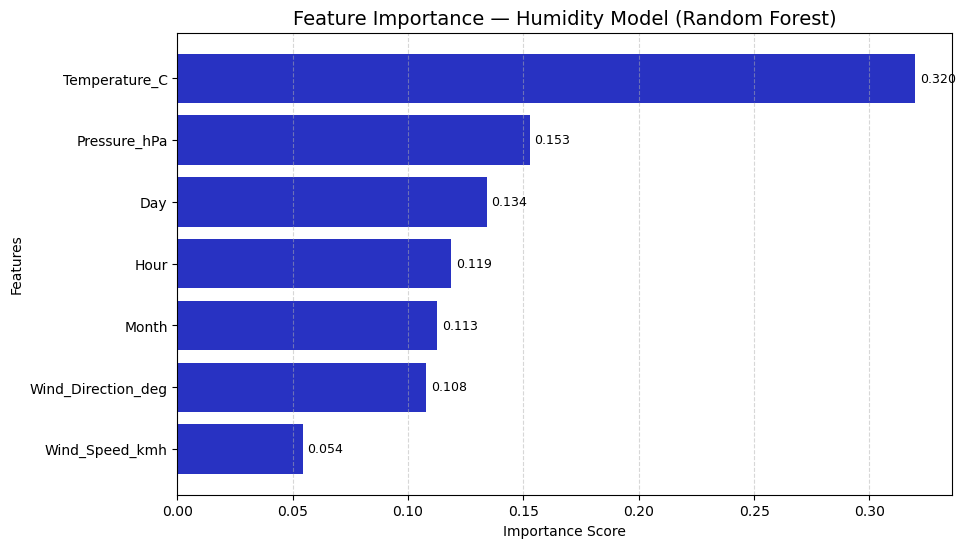

In [14]:
# Convert to array
imp = np.array(importances)

# Sort features by importance (descending)
sorted_idx = np.argsort(imp)
sorted_features = np.array(features)[sorted_idx]
sorted_imp = imp[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_imp, color='#2832C2')

# Add numeric value labels
for i, v in enumerate(sorted_imp):
    plt.text(v + 0.002, i, f"{v:.3f}", va='center', fontsize=9)

plt.title("Feature Importance — Humidity Model (Random Forest)", fontsize=14)
#include X-axis label
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

Here it can be seen than temperature has the biggest importance for humidity forecast. Pressure, hour, month and wind direction has also importance for humidity prediction.

#### 2. Prediction with additional parameters

Add lag features and retrain model.

In [15]:
train_dallas["Hum_lag1"] = train_dallas["Humidity_pct"].shift(1)
train_dallas["Hum_lag24"] = train_dallas["Humidity_pct"].shift(24)
train_dallas["Hum_roll24"] = train_dallas["Humidity_pct"].rolling(24).mean()


In [16]:
train_dallas = train_dallas.dropna().reset_index(drop=True)


In [17]:
features = [
    "Temperature_C",
    "Pressure_hPa",
    "Wind_Speed_kmh",
    "Wind_Direction_deg",
    "Month",
    "Day",
    "Hour",
    "Hum_lag1",
    "Hum_lag24",
    "Hum_roll24"
]

X = train_dallas[features]
y = train_dallas["Humidity_pct"]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=25,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

X = train_dallas[features]
y = train_dallas["Humidity_pct"]

model.fit(X, y)


RandomForestRegressor(max_depth=25, min_samples_leaf=2, n_estimators=400,
                      n_jobs=-1, random_state=42)

In [20]:
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("MAE (Dallas):", mae)
print("RMSE (Dallas):", rmse)

MAE (Dallas): 2.101962894676161
RMSE (Dallas): 3.308970023796048


In [21]:
#MAE (Dallas): 2.101962894676161
#RMSE (Dallas): 3.3089700237960487

In [22]:
#MAE (Montreal): 1.9803414608246726
#RMSE (Montreal): 3.119739986038711

In [23]:
#MAE (Toronto): 2.2871753219840185
#RMSE (Toronto): 3.5433154237063613

Mean error is about 2%. It is six-times better forecasting than without lag features. Lets see importances.

In [24]:
importances = model.feature_importances_
print("len(features):", len(features))
print("len(importances):", len(importances))


len(features): 10
len(importances): 10


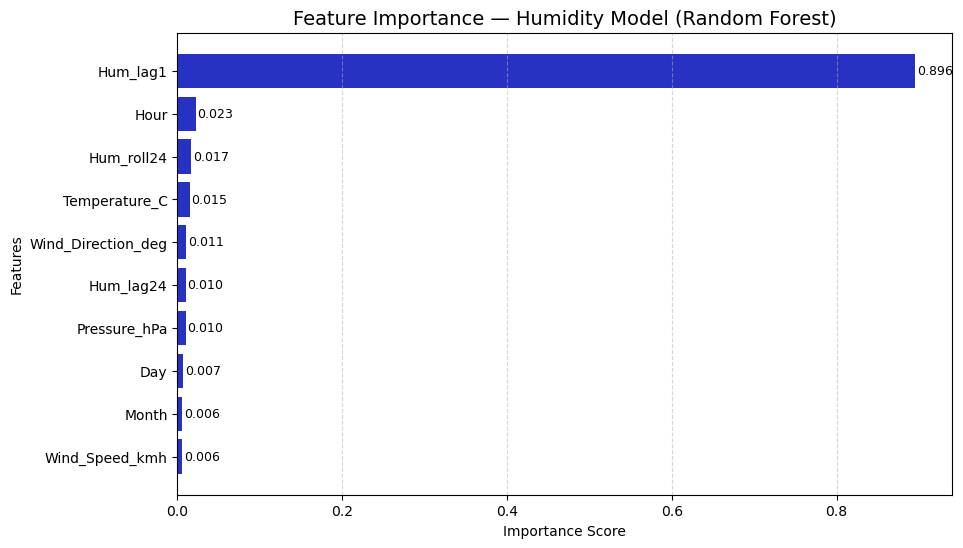

In [25]:
# Convert to array
imp = np.array(importances)

# Sort features by importance (descending)
sorted_idx = np.argsort(imp)
sorted_features = np.array(features)[sorted_idx]
sorted_imp = imp[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_imp, color='#2832C2')

# Add numeric value labels
for i, v in enumerate(sorted_imp):
    plt.text(v + 0.002, i, f"{v:.3f}", va='center', fontsize=9)

plt.title("Feature Importance — Humidity Model (Random Forest)", fontsize=14)
#include X-axis label
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

The situation is similar to that with temperature forecasting. The importance of features with a one-hour delay dominates. Temperature has a negligible impact on humidity forecasting.

#### 3. Testing random forest model on actual weather data

In [26]:
test_dallas  = pd.read_csv("C:/PythonGIS/dataanalysis/proj/new_test_data/weather_Dallas_2023.csv")


In [27]:
test_dallas["Hour"] = pd.to_datetime(test_dallas["Time"]).dt.hour


C:\Users\batur\AppData\Local\Temp\ipykernel_2684\3764849308.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_dallas["Hour"] = pd.to_datetime(test_dallas["Time"]).dt.hour


In [28]:
test_dallas["Hum_lag1"] = test_dallas["Humidity_pct"].shift(1)
test_dallas["Hum_lag24"] = test_dallas["Humidity_pct"].shift(24)
test_dallas["Hum_roll24"] = test_dallas["Humidity_pct"].rolling(24).mean()


In [29]:
test_dallas = test_dallas.dropna().reset_index(drop=True)


In [30]:
features = [
    "Temperature_C",
    "Pressure_hPa",
    "Wind_Speed_kmh",
    "Wind_Direction_deg",
    "Month",
    "Day",
    "Hour",
    "Hum_lag1",
    "Hum_lag24",
    "Hum_roll24"
]

X_test = test_dallas[features]
y_test = test_dallas["Humidity_pct"]


In [31]:
y_pred_test = model.predict(X_test)


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Humidity MAE (Dallas 2023 Test):", mae)
print("Humidity RMSE (Dallas 2023 Test):", rmse)

Humidity MAE (Dallas 2023 Test): 5.058807446860827
Humidity RMSE (Dallas 2023 Test): 6.5895581612486325


In [33]:
#Humidity MAE (Dallas 2023 Test): 5.058807446860827
#Humidity RMSE (Dallas 2023 Test): 6.589558161248633

In [34]:
#Humidity MAE (Toronto 2023 Test): 4.48356831250108
#Humidity RMSE (Toronto 2023 Test): 5.838268200549654

In [35]:
#Humidity MAE (Montreal 2023 Test): 4.109
#Humidity RMSE (Montreal 2023 Test): 5.525

Mean error is 4-5%. RMSE is 5-6%. Prediction for Montreal and Toronto performs prediction for Dallas. It was expected, because humidity depends of precipitation and Dallas placed in warmer climate zone with less predictable weather conditions.

In [36]:
test_dallas["Datetime"] = pd.to_datetime(
    test_dallas["Year"].astype(str) + "-" +
    test_dallas["Month"].astype(str) + "-" +
    test_dallas["Day"].astype(str) + " " +
    test_dallas["Time"].astype(str)
)

In [37]:
test_dallas["Predicted_Hum"] = y_pred_test

In [38]:
jan_feb_mar = test_dallas[(test_dallas["Month"] == 1) | 
                        (test_dallas["Month"] == 2) | 
                        (test_dallas["Month"] == 3)]

In [39]:
print(jan_feb_mar.shape)


(2136, 17)


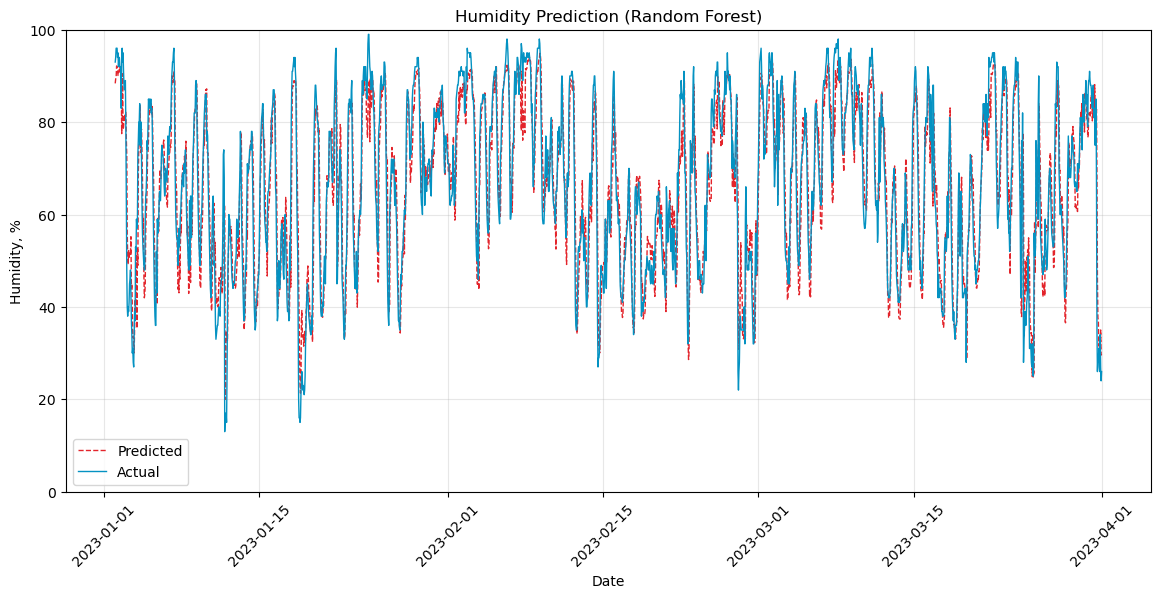

In [40]:
plt.figure(figsize=(14,6))

plt.plot(jan_feb_mar["Datetime"], jan_feb_mar["Predicted_Hum"], 
         label="Predicted", color='#E3242B', linewidth=1, linestyle="--")

plt.plot(jan_feb_mar["Datetime"], jan_feb_mar["Humidity_pct"], 
         label="Actual", color='#0492C2', linewidth=1)

plt.title("Humidity Prediction (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Humidity, %")
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.ylim(0, 100)

plt.savefig(
    "C:/PythonGIS/dataanalysis/proj/result/dallas_hum_jan_feb_mar.svg",
    format="svg",
    bbox_inches='tight'
)
plt.show()


**Repeat same for Montreal and Toronto.**